In [2]:
import opensim as osim
import numpy as np
import os
import matplotlib.pyplot as plt
import pandas as pd

In [ ]:
current_path = os.getcwd()
#geometries_path = current_path + '\Geometry'

#Load model
model = osim.Model(f'{current_path}\GripForceModels\Grip_Model_Flexed.osim')
state = model.initSystem()

#modelViz = model.getVisualizer()
#modelViz.addDirToGeometrySearchPaths(geometries_path)


#Instantiate forward dynamics tool
forwardDyn = osim.ForwardTool()

#Simulation time range
startTime = 0.0
endTime = 0.15

#Set forward dynamics options and load controls
forwardDyn.setModel(model)
controller = osim.PrescribedController(f'{current_path}\GripForceModels\controls_Flexed.sto')
controllerSet = forwardDyn.getControllerSet()
controllerSet.adoptAndAppend(controller)
forwardDyn.addControllerSetToModel()
forwardDyn.setInitialTime(startTime)
forwardDyn.setFinalTime(endTime)
forwardDyn.setStartTime(startTime)
forwardDyn.setSolveForEquilibrium(True)
forwardDyn.setMaxDT = 0.0001

#Setup analysis set
parentStr = osim.ArrayStr()
parentStr.append("parent")
analysisSet = forwardDyn.getAnalysisSet()

# Add a joint reaction analysis to the tool
jointReactionAnalysis = osim.JointReaction(model)
jointReactionAnalysis.setInFrame(parentStr)
jointReactionAnalysis.setOnBody(parentStr)
jointReactionAnalysis.setName("JointReactionAnalysis")
analysisSet.adoptAndAppend(jointReactionAnalysis)

# Add a force reporter analysis to the tool
forceReporterAnalysis = osim.ForceReporter(model)
analysisSet.adoptAndAppend(forceReporterAnalysis)

forwardDyn.addAnalysisSetToModel()

# Run the simulation
forwardDyn.setResultsDir(current_path)
forwardDyn.setPrintResultFiles(True)
#forwardDyn.run()


#visualizer = osim.VisualizerUtilities
#visualizer.showModel(model)

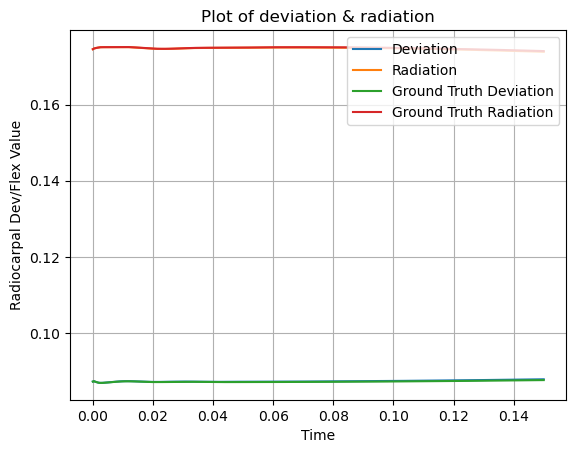

In [39]:
#Plot from resultant states of forward dynamic simulation and compare against comparison resultant states file

results_path = f'{current_path}\_states.sto'
compare_results_path = f'{current_path}\GripForceSimulationResults\Flexed_Posture\grip_strength_states.sto'

# Load data from states .sto file
data = pd.read_csv(results_path, delimiter='\t', skiprows=6)
dataCompare = pd.read_csv(compare_results_path, delimiter='\t', skiprows=6)

# Extract data to plot
time = data['time']
dev = '/jointset/radiocarpal/deviation/value'
flex = '/jointset/radiocarpal/flexion/value'

# Plot the data
plt.plot(time,data[dev], label='Deviation')
plt.plot(time,data[flex], label='Radiation')
plt.plot(time,dataCompare[dev][:len(data[dev])], label='Ground Truth Deviation')
plt.plot(time,dataCompare[flex][:len(data[flex])], label='Ground Truth Radiation') #shifted for visualization
plt.xlabel('Time')
plt.ylabel('Radiocarpal Dev/Flex Value')
plt.title('Plot of deviation & radiation')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

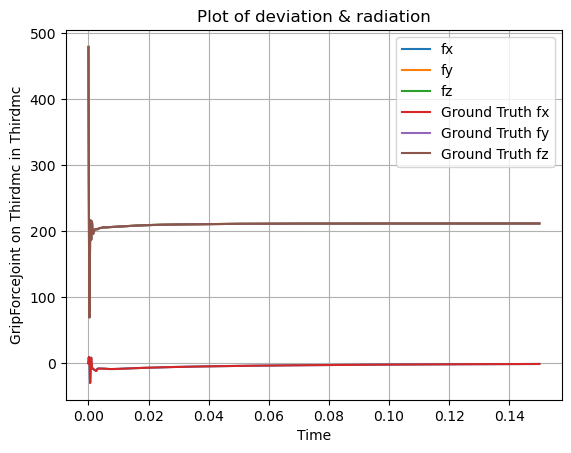

In [40]:
#Plot from resultant jointReactionLoads of forward dynamic simulation and compare against comparison resultant jointReactionLoads file

results_path = f'{current_path}\_JointReactionAnalysis_ReactionLoads.sto'
compare_results_path = f'{current_path}\GripForceSimulationResults\Flexed_Posture\grip_strength_JointReaction_ReactionLoads.sto'

# Load data from states .sto file
data = pd.read_csv(results_path, delimiter='\t', skiprows=11)
dataCompare = pd.read_csv(compare_results_path, delimiter='\t', skiprows=11)


# Extract data to plot
time = data['time']
fx = 'GripForceJoint_on_thirdmc_in_thirdmc_fx'
fy = 'GripForceJoint_on_thirdmc_in_thirdmc_fy'
fz = 'GripForceJoint_on_thirdmc_in_thirdmc_fy'

# Plot the data
plt.plot(time,data[fx], label='fx')
plt.plot(time,data[fy], label='fy')
plt.plot(time,data[fz], label='fz')
plt.plot(time,dataCompare[fx][:len(data[fx])], label='Ground Truth fx')
plt.plot(time,dataCompare[fy][:len(data[fy])], label='Ground Truth fy')
plt.plot(time,dataCompare[fz][:len(data[fz])], label='Ground Truth fz')
plt.xlabel('Time')
plt.ylabel('GripForceJoint on Thirdmc in Thirdmc')
plt.title('Plot of deviation & radiation')
plt.legend()
plt.grid(True)
plt.show()

In [65]:
'''muscleNames = osim.ArrayStr()
muscSet = model.getMuscles()
muscSet.getNames(muscleNames)

for i in range(muscSet.getSize()):
    print(i,muscleNames.get(i))
'''

'muscleNames = osim.ArrayStr()\nmuscSet = model.getMuscles()\nmuscSet.getNames(muscleNames)\n\nfor i in range(muscSet.getSize()):\n    print(i,muscleNames.get(i))\n'

In [60]:
#Calculate grip force using joint reaction load

file = f'{current_path}\GripForceSimulationResults\Flexed_Posture\grip_strength_JointReaction_ReactionLoads.sto'
#file = f'{current_path}\_JointReactionAnalysis_ReactionLoads.sto' #Run Using results
data = pd.read_csv(file, delimiter='\t', skiprows=11)

# Extract data to plot
time = data['time']
fyName = 'GripForceJoint_on_thirdmc_in_thirdmc_fy'
fzName = 'GripForceJoint_on_thirdmc_in_thirdmc_fz'
fy = data[fyName]
fz = data[fzName]

forceDyna = []

#loop through forces and transform into dynamometer reference frame
for i in range(np.size(fy)):
    force = np.array([[fy[i]],[-fz[i]]])
    transform = np.array([[np.cos(np.radians(20)), -np.sin(np.radians(20))],[ np.sin(np.radians(20)), np.cos(np.radians(20))]])
    forceDyna.append((transform@force)[0]/9.81)

# calculate grip force avg and std during simulation
avgForce = np.mean(forceDyna[500:2000],axis=0)
stdForce = np.std(forceDyna[500:2000],axis=0)
print('Average Grip Force = ',avgForce[0],'kg')
print('Standard Deviation: ', stdForce[0], 'kg')

#final grip force
finalForce = np.mean(forceDyna[len(forceDyna)-1])
print('Final Grip Force = ',finalForce, 'kg')

#plt.plot(time,forceDyna)
#plt.title("Grip Force v Time")
#plt.xlabel("Grip Force (kg)")
#plt.ylabel("Time (s)")

Average Grip Force =  23.288359742275276 kg
Standard Deviation:  0.05316754101624833 kg
Final Grip Force =  23.353890556362714 kg
